In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.special import ellipe
from scipy.special import ellipk
from scipy.interpolate import lagrange
from scipy.interpolate import InterpolatedUnivariateSpline

## User input

In [2]:
user = False
raddens = "../data/gasmsd_kpc_linear.txt"      # Gas density with 2 columns, units: KPC, MSUN/PC^2
units = 'KPC,MSUN/PC**2'
zlaw = 2                            # Case 2: sech-squared density law
mode = zlaw                         # Density distribution mode
radii = np.arange(0.001,13,0.1)

# Parameters
G = 0.00000431158                   # Gravitational constant (KPC/MSUN*(KM/S)^2)  
CONSTANT = 2.0 * np.pi * G / 3.0
EPS = 1
z0 = 0.93
distance = 16.5                    # Distance in MPC
h = 10.0                           # GUESS: radial scale-length (KPC)
dens0 = 10**2.4                    # GUESS: central surface density (MSUN/PC^2): from Fig 8. Paper 13

## Density profile

In [3]:
def DensityProfile(user=user,raddens=raddens,units=units,mode=mode,dens0=dens0,h=h):
    
    ##################################
    # Case 1: Import density profile #
    ##################################
    
    if user == True:
        if units == 'KPC,MSUN/PC**2':
            mudata = np.loadtxt(raddens)
            if np.shape(np.loadtxt(raddens))[1] == 2:     # this just checks if the file has 2 or 4 columns
                xdinp, ydinp = mudata.T
            if np.shape(np.loadtxt(raddens))[1] == 4:
                xdinp, ydinp, xerror, yerror = mudata.T

        if units == 'ARCSEC,MAG/ARCSEC**2':
            mudata = np.loadtxt(raddens)
            if np.shape(np.loadtxt(raddens))[1] == 2:
                xdinp, ydinp = mudata.T
            if np.shape(np.loadtxt(raddens))[1] == 4:
                xdinp, ydinp, xerror, yerror = mudata.T

            # Conversion
            # ARCSEC to KPC
            xdinp = 4.8481E-3 * distance * xdinp

            # MAG/ARCSEC^2 to MSUN/PC^2
            ydinp = 10**(-0.4 * ydinp)
            ydinp = (4.8481E-3 * distance)**(-2) * ydinp

        LEN1 = len(xdinp)                   # GUESS: defined as length of radius array
        LEN2 = len(ydinp)                   # GUESS: defined as lenght of density array
        ndinp = LEN2                        # number of surface densities. GUESS: length of density array again
        rcut = xdinp[ndinp-1]               # takes second to last radius value
        delta = rcut - xdinp[ndinp-2]       # difference between the second to last radius value and the third to last radius value
    
    
    #####################################
    # Case 2: Calculate density profile #
    #####################################
    
    if user == False:
    
        # User need to provide dens0 (in MSUN/PC^2) and h (in KPC)
        dens0 = dens0           # central density of exponential DISK
        # convert disk central surface brightness from MAG/ARCSEC^2 to MSUN/KPC^2
        #dens0 = 10**(-0.4 * dens0)       
        #dens0 = (4.8481E-3 * distance)**(-2) * dens0
        #dens0 = dens0 * 1.0e6        
        #print("dens0 = {:.4}".format(dens0))

        h = h                   # radial scale length
        z0 = 0.2*h              # scale height of DISK in kpc [0.0]. 
                                  # note: The integration in Z is the most time consuming part
                                  # of the calculation. For example it takes about 0.2 seconds
                                  # to calculate a point on the rotation curve for a disk with zero
                                  # thickness, and about 2 seconds for a disk with non-zero thickness.
        rcut = 4*h              # cutoff radius
        delta = 0.2*h           # softening parameter of DISK in kpc [0.0]. It may be wise
                                  # to have a non-zero softening in case of a truncated disk, 
                                  # because then the sharp features in the calculated rotation 
                                  # curve will be smoothed out. A softening parameter of about 
                                  # 0.2 scale lengths would be sufficient.

        # Now calculate the surface densities
        LEN1 = 100
        LEN2 = 100
        xdinp = np.zeros(LEN2-1)    # radii surface density
        ydinp = np.zeros(LEN2-1)    # surface densities
        rdinp = rcut + delta      # max radius, where galaxy ends
        ndinp = LEN2 - 1          # number of surface densities
        xstep = rdinp / (ndinp - 1)        # step in radius

        i = 0                              # counter 
        while i < ndinp:
            # Casertano's piecewise function, where do they calculate partial derivative drho/du??
            xdinp[i] = x = xstep * i
            if x >= rcut and delta > 0.0:
                #y = -(1/delta) * dens0 * np.exp(-rcut/h)
                y = dens0 * np.exp(-rcut/h)*(rcut+delta-x)/delta
            elif x >= rdinp:
                y = 0.0                    # end of disk
            else:
                #y = -(1/h) * dens0 * np.exp(-x/h) # exponential disk
                y = dens0 * np.exp(-x/h)
            ydinp[i] = y
            i += 1
    return xdinp, ydinp, ndinp, rcut, delta, LEN1, LEN2

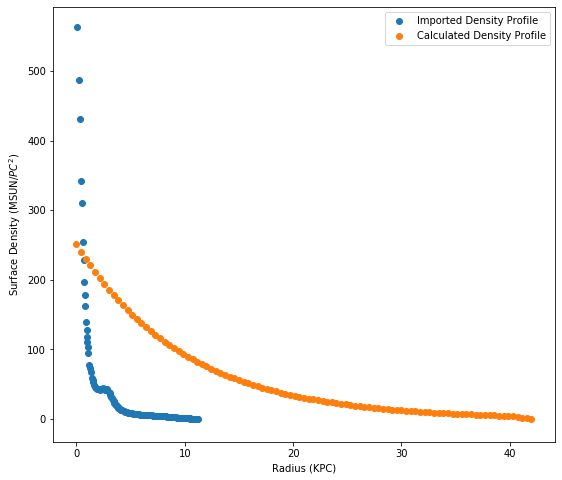

In [4]:
# Plot 
plt.figure(figsize=(9,8))
xdinp_imported = DensityProfile(user=True)[0]
ydinp_imported = DensityProfile(user=True)[1]
plt.scatter(xdinp_imported,ydinp_imported, label="Imported Density Profile")

xdinp_calculated = DensityProfile(user=False)[0]
ydinp_calculated = DensityProfile(user=False)[1]
plt.scatter(xdinp_calculated,ydinp_calculated, label="Calculated Density Profile")
plt.xlabel("Radius (KPC)")
plt.ylabel("Surface Density (MSUN/$PC^2$)")
plt.legend()
plt.show()

## Define radius and density points

In [5]:
xdinp = DensityProfile()[0]
ydinp = DensityProfile()[1]

## Density distribution

In [6]:
# There are three distribution laws possible; 
# the Van der Kruit and Searle law (SECH-SQUARED): D(Z)=sech(Z/Z0)**2/Z0,
# an exponential density law (EXPONENTIAL): D(Z)=exp(-Z/Z0)/Z0 
# a simple sech law (SIMPLE-SECH): D(Z)=2*sech(Z/Z0)/Z0/PI. 

# case 1 is a flat disk, z0 = 0
#####################################

# Sech-squared law:
def denzed_case2(z,z0): 
    r = np.cosh(z / z0)
    r = r * r * z0                 # This is multiplied by z0 but in Caserano Eq 2 there isn't any z0
    r = 1.0 / r
    return r

# Exponential:
def denzed_case3(z,z0):
    r = np.exp(-z / z0) /z0
    return r

# Simple-sech
def denzed_case4(z,z0):
    r = 2 / z0 / np.pi / np.cosh(z/z0)
    return r

def denzed(z,z0,mode):
    #mode = input("Which Z density law? 2 or 3 or 4: ")
    #The above results in the user being asked for every point entered; this was likely used as a backend.
    if mode == 2:
        return denzed_case2(z,z0)
    if mode == 3:
        return denzed_case2(z,z0)
    if mode == 4:
        return denzed_case4(z,z0)
    else:
        return np.nan
        print("Error occured in denzed; no mode selected. Returned nan.")

In [7]:
# Casertano Eq 2
def drho_rz(densit,z,z0,mode):
    return densit * denzed(z,z0,mode)  # In Casertano's eq 2, the cosh term is multiplied by rho0(r) 
                                       # so I assume this is the same as the calculated density array

## Functions

In [8]:
# Casertano Eq 5
def px(r,u,z):
    x = (r**2 + u**2 + z**2)/(2*r*u)
    return x - (np.sqrt((x**2)-1))

In [9]:
# Complete elliptic integral
def K(r,u,z):
    return ellipk(px(r,u,z)) - ellipe(px(r,u,z))

In [10]:
# Inner function
def innerfunc(r,u,z,densit,z0,mode):
    return (4 * np.pi * G) * (drho_rz(densit,z,z0,mode) * K(r,u,z) * 2 * np.sqrt(u)) / (np.pi * np.sqrt(r * px(r,u,z)))

## Interpolation

In [11]:
def interpd(x,y):
    #return lagrange(x,y)                # Lagrange interpolation didn't work well so I used Univariate Spline
    return InterpolatedUnivariateSpline(x,y,k=5)

# Calculate the density values at the sampling radii, using Lagrange Interpolation
polynomial = interpd(xdinp,ydinp)        # define the polynomial that's calculated, type: numpy.poly1d
densit = polynomial(radii)               # evaluate values at the sampling radii

In [12]:
print(densit)
print(ydinp)

[251.16352554 248.66440673 246.19015454 243.74052156 241.31526284
 238.91413585 236.53690048 234.183319   231.85315604 229.5461786
 227.26215596 225.00085972 222.76206376 220.54554419 218.35107936
 216.17844982 214.02743831 211.89782971 209.78941108 207.70197156
 205.63530241 203.58919697 201.56345061 199.55786077 197.57222688
 195.60635037 193.66003467 191.73308512 189.82530905 187.93651567
 186.06651609 184.21512332 182.38215222 180.56741949 178.77074364
 176.99194502 175.23084574 173.4872697  171.76104252 170.05199159
 168.359946   166.68473655 165.02619571 163.38415763 161.7584581
 160.14893455 158.55542602 156.97777317 155.41581823 153.869405
 152.33837884 150.82258665 149.32187684 147.83609934 146.36510557
 144.90874844 143.4668823  142.03936297 140.62604769 139.22679514
 137.84146538 136.46991988 135.11202149 133.76763442 132.43662421
 131.11885779 129.81420335 128.52253045 127.2437099  125.97761383
 124.72411563 123.48308995 122.25441267 121.03796094 119.83361311
 118.64124873 

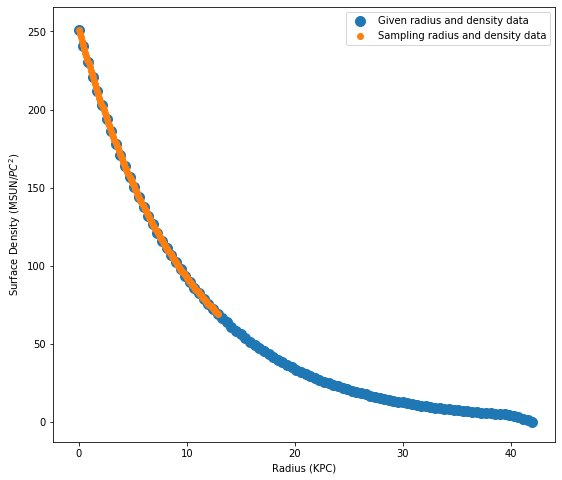

In [13]:
# Plot 
plt.figure(figsize=(9,8))
plt.scatter(xdinp,ydinp, label="Given radius and density data", s=100)
plt.scatter(radii,densit, label="Sampling radius and density data")
plt.xlabel("Radius (KPC)")
plt.ylabel("Surface Density (MSUN/$PC^2$)")
plt.legend()
plt.show()

## Integration

In [14]:
# Integrate inner function
innerfunc2 = lambda z,r,u,densit,z0,mode: innerfunc(r,u,z,densit,z0,mode)
innerintegr1 = lambda r,u,densit,z0,mode: quad(innerfunc2, 0, np.inf, args=(r,u,densit,z0,mode,))[0]

In [15]:
# Integrate outer function
innerintegr2 = lambda u,r,densit,z0,mode: innerintegr1(r,u,densit,z0,mode)
radialforce = lambda r,densit,z0,mode: quad(innerintegr2, 0, 125, args=(r,densit,z0,mode,))[0]

## Velocity

In [16]:
radialforce = np.vectorize(radialforce)
velocs = np.sqrt(radii*radialforce(radii,densit,z0,mode))

C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: overflow encountered in double_scalars
  if sys.path[0] == '':
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: overflow encountered in cosh
  # This is added back by InteractiveShellApp.init_path()
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  warnings.warn(msg, IntegrationWarning)
C:\Users\JB\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\integrate\quadpack.py:385: Integr

## Plot

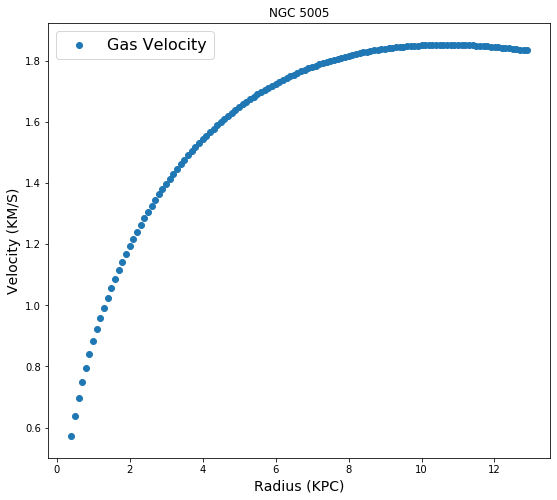

In [17]:
plt.figure(figsize=(9.0,8.0))             
plt.scatter(radii, velocs, linestyle='solid', label='Gas Velocity')
plt.axis('tight');
plt.title('NGC 5005')
plt.xlabel('Radius (KPC)', fontsize=14)
plt.ylabel('Velocity (KM/S)', fontsize=14)
plt.legend(fontsize=16)
plt.show()

In [18]:
print(radii)
print(velocs)

[1.0000e-03 1.0100e-01 2.0100e-01 3.0100e-01 4.0100e-01 5.0100e-01
 6.0100e-01 7.0100e-01 8.0100e-01 9.0100e-01 1.0010e+00 1.1010e+00
 1.2010e+00 1.3010e+00 1.4010e+00 1.5010e+00 1.6010e+00 1.7010e+00
 1.8010e+00 1.9010e+00 2.0010e+00 2.1010e+00 2.2010e+00 2.3010e+00
 2.4010e+00 2.5010e+00 2.6010e+00 2.7010e+00 2.8010e+00 2.9010e+00
 3.0010e+00 3.1010e+00 3.2010e+00 3.3010e+00 3.4010e+00 3.5010e+00
 3.6010e+00 3.7010e+00 3.8010e+00 3.9010e+00 4.0010e+00 4.1010e+00
 4.2010e+00 4.3010e+00 4.4010e+00 4.5010e+00 4.6010e+00 4.7010e+00
 4.8010e+00 4.9010e+00 5.0010e+00 5.1010e+00 5.2010e+00 5.3010e+00
 5.4010e+00 5.5010e+00 5.6010e+00 5.7010e+00 5.8010e+00 5.9010e+00
 6.0010e+00 6.1010e+00 6.2010e+00 6.3010e+00 6.4010e+00 6.5010e+00
 6.6010e+00 6.7010e+00 6.8010e+00 6.9010e+00 7.0010e+00 7.1010e+00
 7.2010e+00 7.3010e+00 7.4010e+00 7.5010e+00 7.6010e+00 7.7010e+00
 7.8010e+00 7.9010e+00 8.0010e+00 8.1010e+00 8.2010e+00 8.3010e+00
 8.4010e+00 8.5010e+00 8.6010e+00 8.7010e+00 8.8010e+00 8.9010